In [1]:
from math import sqrt, log
import glob
import re

from utils import Graph
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt
import numpy as np

T = 87       # K
n = 2.11e22  # cm^-3

def mobility(E):
    a0 = 551.6
    a1 = 7953.7
    a2 = 4440.43
    a3 = 4.29
    a4 = 43.63
    a5 = 0.2053
    T0 = 89

    num = a0 + a1*E + a2*E**(3/2) + a3*E**(5/2)
    den = 1 + (a1/a0)*E + a4*E**2 + a5*E**3

    return (num / den) * (T / T0)**(-3/2)

In [2]:
file_tree = {}

for file in glob.glob('lar-drift-velocity/*.txt'):
    key = int(re.search(r'(\d*)(?:V)', file).group(1))
    if (key in file_tree):
        file_tree[key].append(file)
    else:
        file_tree[key] = [file]

The below plots drift velocity of the simulated electron cloud versus time. The data lines are taken from Li at https://lar.bnl.gov/properties/trans.html. For each bulk field strength, $100$ electrons were spawned and allowed to propagate for $10$ ns.

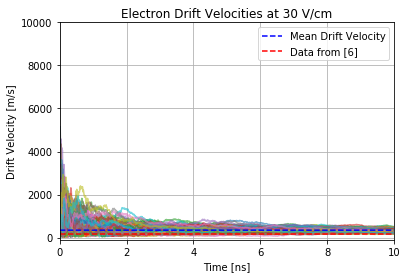

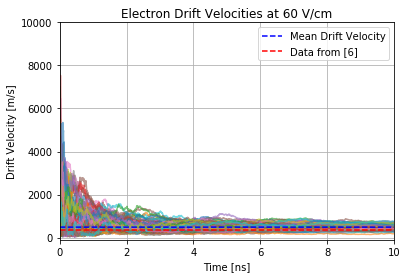

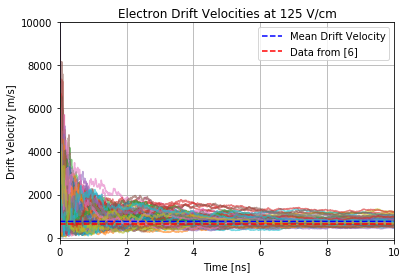

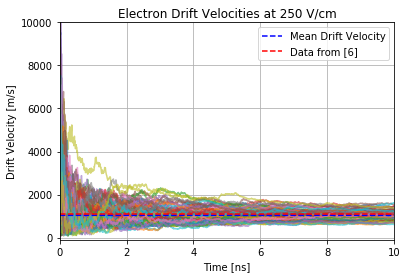

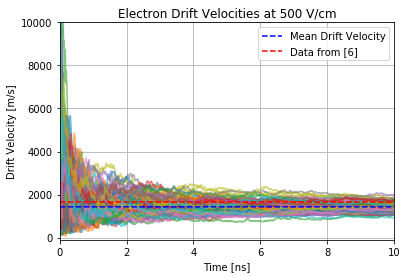

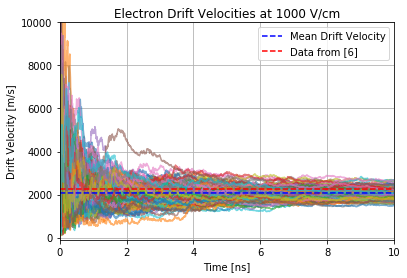

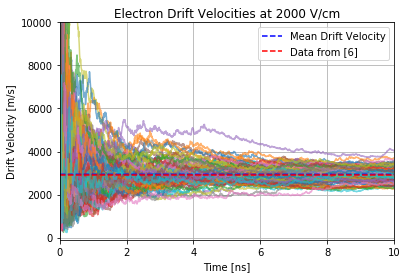

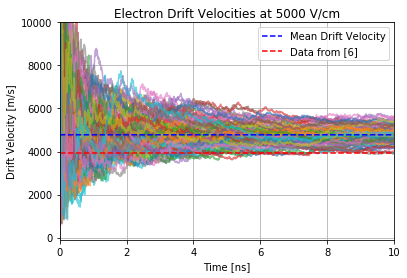

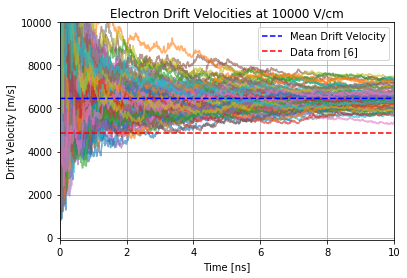

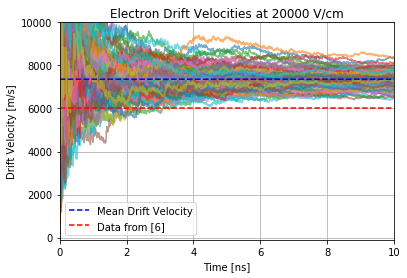

In [3]:
eVs_all = []
bincentres = 0

for key, value in sorted(file_tree.items()):
    group = Graph(value)
    
    time, vel = self.t, self.drift
    ke = group.ke
    
    # plt.rcParams['font.size'] = 14
    # plt.rcParams['font.family'] = 'serif'
    # fig = plt.figure(figsize=(6, 6))
    
    plt.title(f'Electron Drift Velocities at {key} V/cm')
    plt.xlabel('Time [ns]')
    plt.ylabel('Drift Velocity [m/s]')
    
    for i, t in enumerate(time):
        plt.plot(t, vel[i], alpha=0.6)
        
    plt.plot(time[0], np.full(len(time[0]), group.drift_mean()), 'b--', label='Mean Drift Velocity')
    plt.plot([0, 10], [mobility(key * 1e-3) * (key * 1e-2), mobility(key * 1e-3) * (key * 1e-2)], 'r--', label='Data from [6]')
    plt.xlim(0, 10)
    plt.ylim(-100, 10000)
    
    max_ev = np.amax([np.amax(k) for k in ke])
    
    bin_list = np.linspace(0, 2.6, 100)
    H, bins = np.histogram(ke[0], bins=bin_list, density=True)
    
    for i in range(group.n - 1):
        H_, bins_ = np.histogram(ke[i + 1], bins=bin_list, density=True)
        H += H_
        
        
    bincentres = [(bins[i] + bins[i + 1]) / 2. for i in range(len(bins) - 1)]
    eVs_all.append(H)

    plt.grid()
    plt.legend()
    plt.show()
    
    # plt.savefig(f'lar_drift_vel_{key}.pdf', bbox_inches='tight')

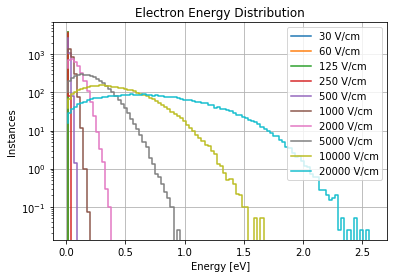

In [4]:
volts = [30, 60, 125, 250, 500, 1000, 2000, 5000, 10000, 20000]

# plt.rcParams['font.size'] = 14
# plt.rcParams['font.family'] = 'serif'
# fig = plt.figure(figsize=(6, 6))

for i, k in enumerate(eVs_all):
    plt.step(bincentres, k, label=f'{volts[i]} V/cm')
    
plt.yscale('log')

plt.title('Electron Energy Distribution')
plt.xlabel('Energy [eV]')
plt.ylabel('Instances')

plt.legend()
plt.grid()
plt.show()

# plt.savefig(f'lar_mean_energy.pdf', bbox_inches='tight')

The below plots projections of the trajectories of the simulations.

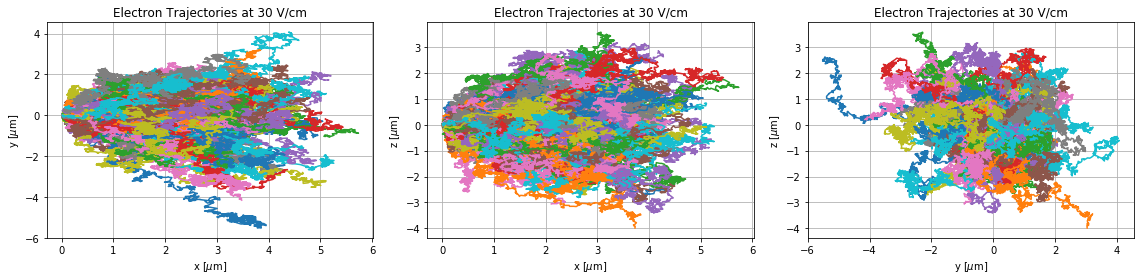

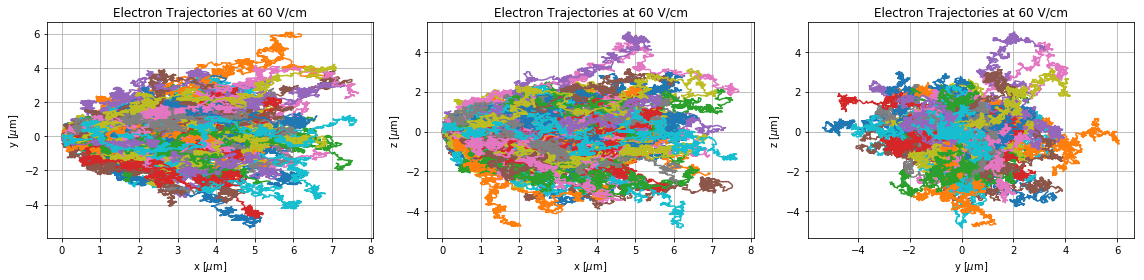

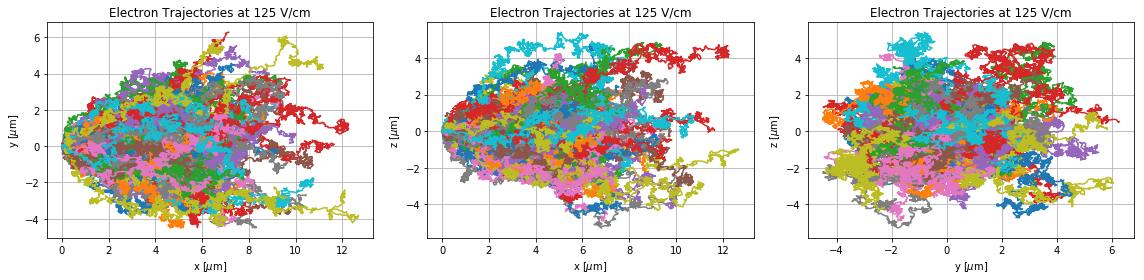

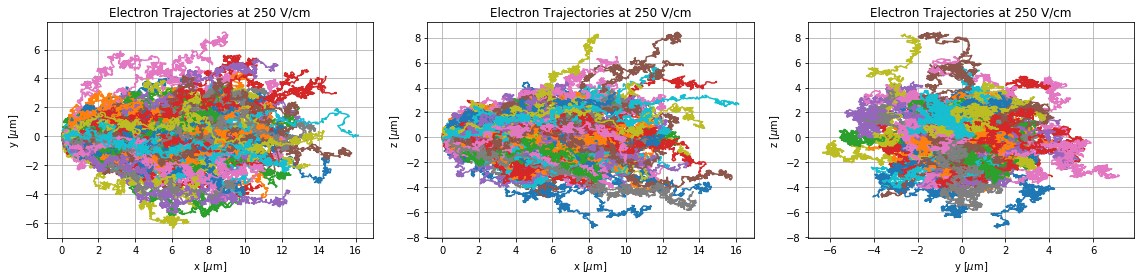

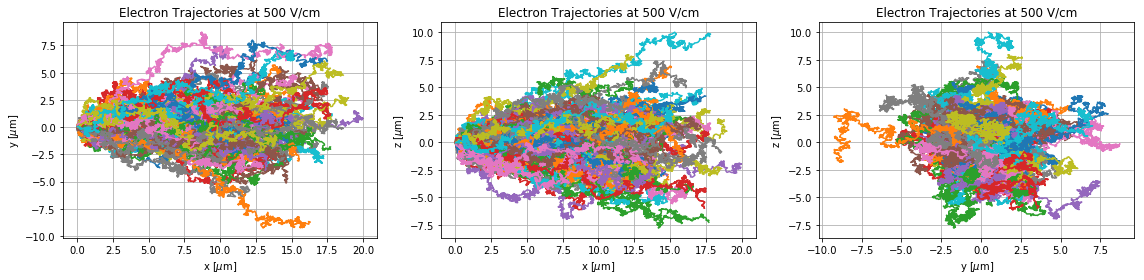

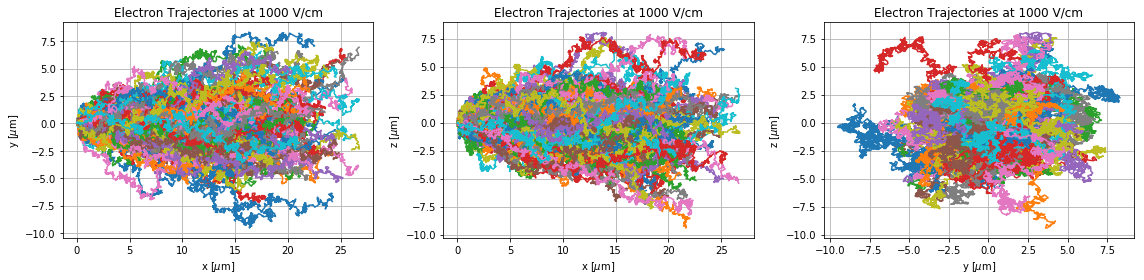

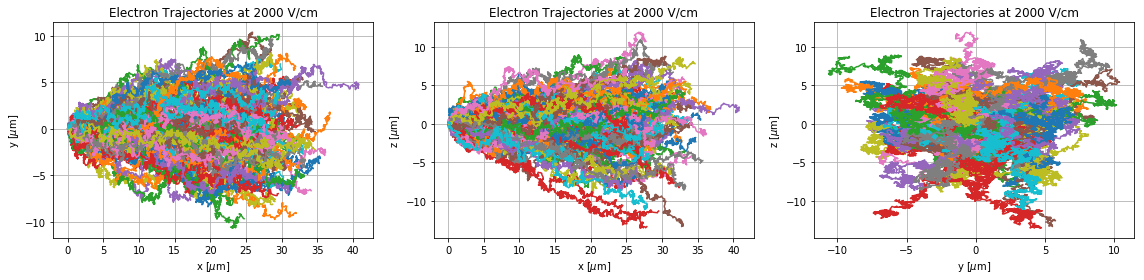

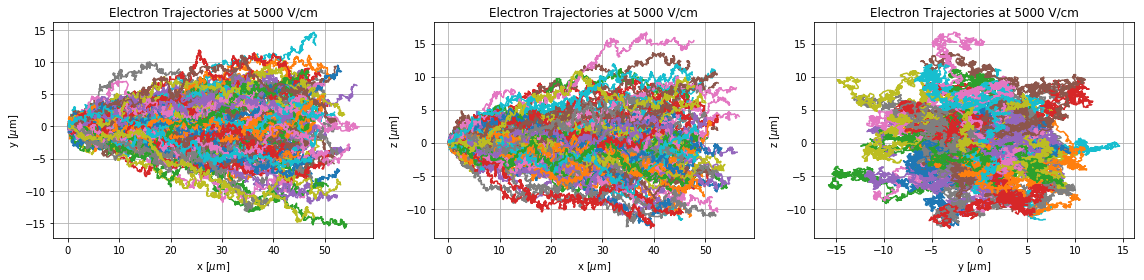

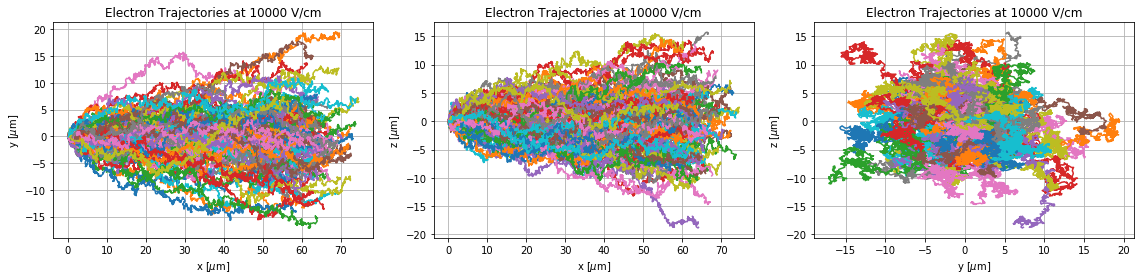

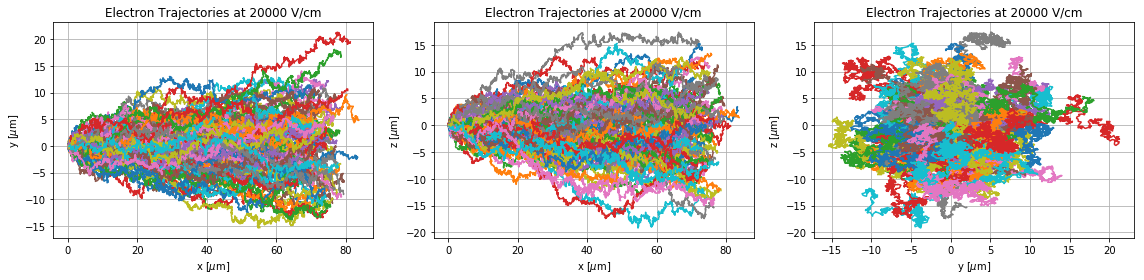

In [5]:
for key, value in sorted(file_tree.items()):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
    
    group = Graph(value)
    
    for i in range(group.n):
        x, y = group.x[i], group.y[i]
        ax1.plot(x, y)
        
    ax1.set_xlabel('x [$\mu$m]')
    ax1.set_ylabel('y [$\mu$m]')
    ax1.set_title(f'Electron Trajectories at {key} V/cm')
    
    ax1.grid()
    
    for i in range(group.n):
        x, z = group.x[i], group.z[i]
        ax2.plot(x, z)
        
    ax2.set_xlabel('x [$\mu$m]')
    ax2.set_ylabel('z [$\mu$m]')
    ax2.set_title(f'Electron Trajectories at {key} V/cm')
    
    ax2.grid()
    
    for i in range(group.n):
        y, z = group.y[i], group.z[i]
        ax3.plot(y, z)
        
    ax3.set_xlabel('y [$\mu$m]')
    ax3.set_ylabel('z [$\mu$m]')
    ax3.set_title(f'Electron Trajectories at {key} V/cm')
    ax3.grid()

    plt.tight_layout()
    plt.show()

The below plots simulated mobility against data. The data from Li et al. is found at https://lar.bnl.gov/properties/trans.html, while the data from Wojcik et al. is found at https://doi.org/10.1088/0022-3727/19/12/011.

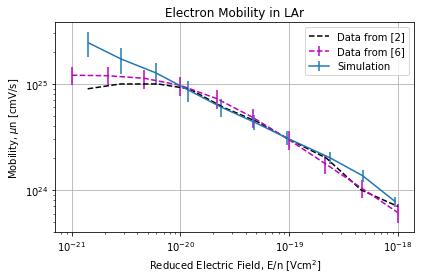

In [6]:
volts = []
means = []
std_devs = []

# plt.rcParams['font.size'] = 14
# plt.rcParams['font.family'] = 'serif'
# fig = plt.figure(figsize=(6, 6))

# From https://lar.bnl.gov/properties/trans.html
c = np.logspace(-21, -18, 10)
d = mobility(c * n * 1e-3) * n

# From https://doi.org/10.1088/0022-3727/19/12/011
a = [1.4e-21, 2.8e-21, 6.2e-21, 1.2e-20, 2.5e-20, 5.1e-20, 1e-19, 2.2e-19, 4.6e-19, 1e-18]
b = [9e24, 10e24, 10e24, 9e24, 6e24, 4.4e24, 3e24, 2e24, 1e24, 7e23]

plt.plot(a, b, 'k--', label='Data from [2]')
plt.errorbar(c, d, color='m', ls='--', yerr=(0.2 * d), label='Data from [6]')

for key, value in sorted(file_tree.items()):
    graph = Graph(value)
    volts.append(key)
    means.append(graph.drift_mean())
    std_devs.append(graph.drift_std_dev())

x, y, err = [], [], []

for j, mu in enumerate(means):
    x.append(float(volts[j]) / n)
    y.append(means[j] * (n / float(volts[j])) * 1e2)
    err.append(std_devs[j] * (n / float(volts[j])) * 1e2)

plt.errorbar(x, y, yerr=err, label=f'Simulation')

plt.xlabel('Reduced Electric Field, E/n [Vcm$^2$]')
plt.ylabel('Mobility, $\mu$n [cmV/s]')
plt.title('Electron Mobility in LAr')

plt.xscale('log')
plt.yscale('log')

plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# plt.savefig(f'lar_mobility.pdf', bbox_inches='tight')